# Implementation of Block and Ring Vaccination in the Static Scenario

## Imports

In [1]:
#imports
import numpy as np
from scipy.optimize import fsolve
from pynverse import inversefunc
from sympy import symbols, diff
from functions import *
from math import factorial


## Definition of functions

In [6]:

######################################################################
#process ruling the teleporting step (step 1)
def teleport(prob_vec,n_nodes,p,q,d,r_avg,k_avg,t):

    for k in range(len(prob_vec)): #for each degree

        #P IS THE MATRIX FOR THE DEGREE DISTRIBUTION
        p[t][k] = (1 / (n_nodes-t)) * (p[t-1, k] * (n_nodes-t+1) - d[t, k] +  r_avg[t] * (q[t-1, k] - (q[t-1, k-1] if k > 0 else 0))) #update p
    
    #K_AVG IS THE AVERAGE DEGREE OF THE CORRESPONDING DEGREE DISTRIBUTION
    k_avg[t] = np.sum(np.arange(len(prob_vec)) * p[t]) #consequently, update k_avg


    #Q IS THE EXCESS DEGREE DISTRIBUTION
    #D IS THE DEGREE DISTRIBUTION AT THE PREVIOUS STEP
    #R IS THE AVERAGE DEGREE OF THE EXCESS DEGREE DISTRIBUTION
    for k in range(len(prob_vec)): #and update q, d and r_avg
        q[t][k] = ((k+1)*p[t,k+1]) / k_avg[t] if k < len(prob_vec)-1 else 0
        d[t+1, k] = p[t, k]
    r_avg[t+1] = np.sum(np.arange(len(prob_vec)) * d[t+1])

    #HERE WE SOLVE THE EQUATION FOR THE SIZE OF THE GIANT COMPONENT
    x_intersect = fsolve(lambda x: g_1(x,p[t],k_avg[t])-x,0.05)
    size_gc = (1-g_0(x_intersect,p[t]))[0]

    return p,k_avg, q,d,r_avg,size_gc

######################################################################

#process ruling the vaccination step (step 2)
def vaccination(p,radius,n_nodes,t,Ring,k_avg,q,d,r_avg,prob_vec):

    #####
    alpha = 1
    mean_deg = sum([i*p[t][i] for i in range(len(p[t]))])
    sq_mean_deg = sum([i**2*p[t][i] for i in range(len(p[t]))])
    removed_nodes = sum([((((sq_mean_deg-mean_deg)/mean_deg)**(i-1))*mean_deg) for i in range(1,radius+1)])
    reintroduced_nodes = sum([((((sq_mean_deg-mean_deg)/mean_deg)**(i-1))*mean_deg) for i in range(radius)])
    remaining_nodes = (n_nodes-t)-removed_nodes
    perc_remaining_nodes = remaining_nodes/(n_nodes-t)
    ####

    #HERE WE SOLVE THE EQUATION FOR THE SIZE OF THE GIANT COMPONENT
    g_01 = (lambda x: sum([p[t][i]*(x**(i)) for i in range(len(p[t]))]))
    f = inversefunc(g_01,y_values = perc_remaining_nodes)
    #print("new f",f)
    x = symbols('x')
    g_12 = (sum([p[t][i]*(x**(i)) for i in range(len(p[t]))]))
    der = diff(g_12,x)
    gen_fun =(1/g_0(f,p[t]))*(g_0(f+(der.subs(x,f)/der.subs(x,1))*(x-1),p[t]))
    degree_distribution_itermediate = []
    for j in range(0,(len(p[t]))):
        df = diff(gen_fun, x, j)
        deg1 = (1/factorial(j))*df.subs(x,0).evalf()
        degree_distribution_itermediate.append(deg1)
    t+=removed_nodes
    t = int(round(t))


    ######### Intermediate step only for ring vaccination: reintroduction of nodes ###########

    if Ring:
        prob_intermediate = [float(k) for k in degree_distribution_itermediate]
        list_degrees = [(n_nodes-t)*i for i in prob_intermediate]

        #add number of 0 degree nodes equal to the number of removed nodes belonging to internal shells
        list_degrees[0]+= sum([(((sq_mean_deg-mean_deg)/mean_deg)**(i-1))*mean_deg for i in range(radius)])
        list_degrees = [list_degrees[i]/sum(list_degrees) for i in range(len(list_degrees))]
        
        #back in time! we need to reintroduce the nodes that were removed
        t -= int(round(reintroduced_nodes))
        p[t] = list_degrees


    else: # if not ring vaccination we can directly update the degree distribution
        p[t] = [float(k) for k in degree_distribution_itermediate]

    k_avg[t] = np.sum(np.arange(len(prob_vec)) * p[t])


    #FINAL UPDATE OF THE DEGREE DISTRIBUTION
    for k in range(len(prob_vec)):
        q[t][k] = ((k+1)*p[t,k+1]) / k_avg[t] if k < len(prob_vec)-1 else 0
        d[t+1, k] = d[t, 0] * 1*p[t, k] + (1 - d[t, 0]) * (alpha *1*p[t, k] + (1-alpha) * q[t-1, k])
    r_avg[t+1] = np.sum(np.arange(len(prob_vec)) * d[t+1])

    return p,k_avg, q,d,r_avg,t

    

### Parameters setting:
- Initial number of nodes;
- Percentage of individuals to vaccinate (phi)
- Initial degree distribution (SF,ER..)
- Ring or Block


In [7]:
n_nodes = 10000
perc_vax = 0.6
prob_vec = prob_list_powerlaw(2.5,3,400)
radius = 2
Ring = True 
remaining_nodes = n_nodes
alpha = 1

### Initialization

In [8]:
t = 0
p = np.zeros((n_nodes+1, len(prob_vec)))
d = np.zeros((n_nodes+1, len(prob_vec)))
q = np.zeros((n_nodes+1, len(prob_vec)))
k_avg = np.zeros(n_nodes+1)
r_avg = np.zeros(n_nodes+1)
# Set initial values
p[0] = prob_vec
q[-1] = p[0]
q[0] = p[0]
d[1] = p[0]
k_avg[0] = np.sum(np.arange(len(prob_vec))*p[0])
r_avg[1] = np.sum(np.arange(len(prob_vec))*p[0])
removed_nodes = 0
size_gc = 1
EVOL_GC = []

### Static Vaccination

#### NB: perc_vax = 1 necessary for having the complete evolution of the GC wrt phi. 
#### Lower values of perc_vax allow to produce the evolution of R vs beta for that specific value. 

In [9]:
while remaining_nodes > n_nodes*(1-perc_vax) and size_gc > 0.005: #stop when the number of remaining nodes is less than the percentage of vaccinated nodes or the size of the giant component is less than 0.005
    
    t+=1 #update time 

#################### teleportation #####################

    
    #solve the equation to find the size of the giant component after the teleportation 

    p,k_avg, q,d,r_avg,size_gc = teleport(prob_vec,n_nodes,p,q,d,r_avg,k_avg,t)

    remaining_nodes = n_nodes-t

    EVOL_GC.append((remaining_nodes/n_nodes,(remaining_nodes/n_nodes)*size_gc)) #store the evolution of the giant component wrt the number of remaining nodes
    
    print("time: ",t,"remaining nodes: ",remaining_nodes,"size GC: ",size_gc)
    


############## vaccination ####################

    p,k_avg, q,d,r_avg,t = vaccination(p,radius,n_nodes,t,Ring,k_avg,q,d,r_avg,prob_vec)


################################################

#final steps

for i in range(t,n_nodes): #add zeros at the end: we early stopped when the GC is smaller than 0.005
    EVOL_GC.append(((n_nodes-i)/n_nodes,0))

#find last row of p with non zero elements (before we defined p with zeros!!! hence we need to find the last row with non zero elements)
for i in range(len(p)-1,0,-1):
    if sum(p[i])>0:
        last_row = i
        break

#this is the probability degree distribution of the network after vaccination of perc_vax nodes
prob_vec_final = p[last_row]


#solve the equation to find the size of the giant component after the whole process

mean= sum([prob_vec_final[i]*i for i in range(len(prob_vec_final))])
impact = []
step = np.linspace(0,1,100)
for i in range(len(step)):
    x_intersect = fsolve(lambda x: 1-step[i]+step[i]*g_1(x,prob_vec_final,mean) - x,0.05)
    impact.append(float(list(abs((1-g_0(x_intersect,prob_vec_final)))*(1-perc_vax))[0]))



time:  1 remaining nodes:  9999 size GC:  1.0
time:  32 remaining nodes:  9968 size GC:  0.9993995638587745
time:  61 remaining nodes:  9939 size GC:  0.9988023011966208
time:  90 remaining nodes:  9910 size GC:  0.9982040423198271
time:  119 remaining nodes:  9881 size GC:  0.9976046976075897
time:  147 remaining nodes:  9853 size GC:  0.9970042410289861
time:  175 remaining nodes:  9825 size GC:  0.9964025913531295
time:  203 remaining nodes:  9797 size GC:  0.9957996697305281
time:  230 remaining nodes:  9770 size GC:  0.9951954606126264
time:  257 remaining nodes:  9743 size GC:  0.9945898934615194
time:  284 remaining nodes:  9716 size GC:  0.9939828989926656
time:  311 remaining nodes:  9689 size GC:  0.9933744106565655
time:  337 remaining nodes:  9663 size GC:  0.9927644248516654
time:  363 remaining nodes:  9637 size GC:  0.9921528834540358
time:  389 remaining nodes:  9611 size GC:  0.9915397280565278
time:  414 remaining nodes:  9586 size GC:  0.990924963006537
time:  439 re

### Plot

We plot the evolution of the Giant Component wrt the percentage of vax individuals (GC vs Phi) and the size of the epidemic wrt the infection probability (R vs Beta)


NB. In order to have the first plot complete, we have to set a high value for perc_vax. On the other hand, we can set a customized value and obtain as second plot the evolution of the impact for that specific value of phi. 

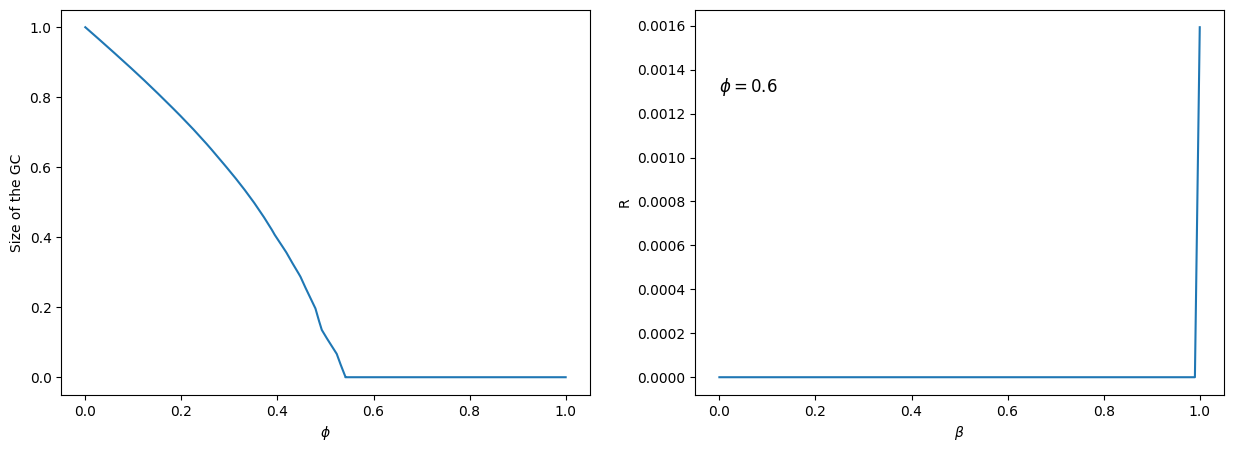

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot([1-i[0] for i in EVOL_GC],[i[1] for i in EVOL_GC])
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel("Size of the GC")
ax[1].plot(step,impact)
ax[1].set_xlabel(r"$\beta$")
ax[1].set_ylabel("R")
#add text in ax1
ax[1].text(0.1,0.8,r"$\phi = $"+str(perc_vax),fontsize=12,verticalalignment='center',horizontalalignment='center',transform=ax[1].transAxes)
plt.show()
